### 1. Data Cleaning & exploration ----------------------------------------------------------------------------------------------------------

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary
from dmba.metric import AIC_score
from dmba import regressionSummary
%matplotlib inline
import matplotlib.pylab as plt
from dmba import gainsChart, liftChart
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


In [53]:
df = pd.read_csv('Airline Customer Satisfaction Survey.csv')
print(df.shape)

(25976, 25)


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [55]:
# Dropping the 'Unnamed: 0' and 'id' columns
df_new = df.drop(['Unnamed: 0', 'id'], axis=1)

Categorical variables identified : Gender, Customer Type, Type of Travel, Class, satisfaction

In [56]:
# Convert categorical variables to dummy variables
categorical_variables = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
df_new = pd.get_dummies(df_new,columns=categorical_variables,drop_first=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                25976 non-null  int64  
 1   Flight Distance                    25976 non-null  int64  
 2   Inflight wifi service              25976 non-null  int64  
 3   Departure/Arrival time convenient  25976 non-null  int64  
 4   Ease of Online booking             25976 non-null  int64  
 5   Gate location                      25976 non-null  int64  
 6   Food and drink                     25976 non-null  int64  
 7   Online boarding                    25976 non-null  int64  
 8   Seat comfort                       25976 non-null  int64  
 9   Inflight entertainment             25976 non-null  int64  
 10  On-board service                   25976 non-null  int64  
 11  Leg room service                   25976 non-null  int

Treatment of NA values -> not to drop the columns but to instead drop the rows. 

In [57]:
# Drop rows with NA values
df_new = df_new.dropna()

In [58]:
print(df_new.shape)

(25893, 24)


In [59]:
#double checking that NA rows were dropped. 
df_new.isna().sum()

Age                                  0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Gender_Male                          0
Customer Type_disloyal Customer      0
Type of Travel_Personal Travel       0
Class_Eco                            0
Class_Eco Plus                       0
satisfaction_satisfied               0
dtype: int64

In [60]:
df_new.duplicated().sum()

0

### DATA EXPLORATION

##### Is it a balanced dataset?

0: 14528 (56.11%)
1: 11365 (43.89%)


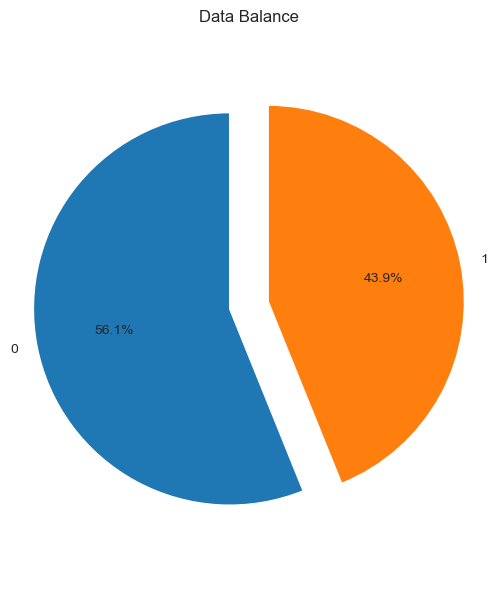

In [61]:


def plot_data_balance(column):
    counts = column.value_counts()
    labels = counts.index
    sizes = counts.values
    explode = [0.1] * len(counts)  

    # Calculate data balance ratios
    total_samples = len(column)
    ratios = sizes / total_samples * 100

    # Print data balance ratios
    for label, size, ratio in zip(labels, sizes, ratios):
        print(f"{label}: {size} ({ratio:.2f}%)")

    # Plot pie chart
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  
    plt.title("Data Balance")

    plt.tight_layout()  
    plt.show()

plot_data_balance(df_new["satisfaction_satisfied"])  

###### Visulize the features

In [62]:
TARGET = 'satisfaction_satisfied'
columns_predictors = [col for col in df_new.columns if col not in [TARGET]]
columns_categorical =['Gender_Male', 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel',
                      'Class_Eco','Class_Eco Plus']
columns_ordinal =['Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']
columns_numerical =['Age', 'Flight Distance','Departure Delay in Minutes', 'Arrival Delay in Minutes']

print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_ordinal: {columns_ordinal}")
print(f"columns_numerical: {columns_numerical}")

TARGET: satisfaction_satisfied
columns_predictors: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Gender_Male', 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus']
columns_categorical: ['Gender_Male', 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus']
columns_ordinal: ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness'

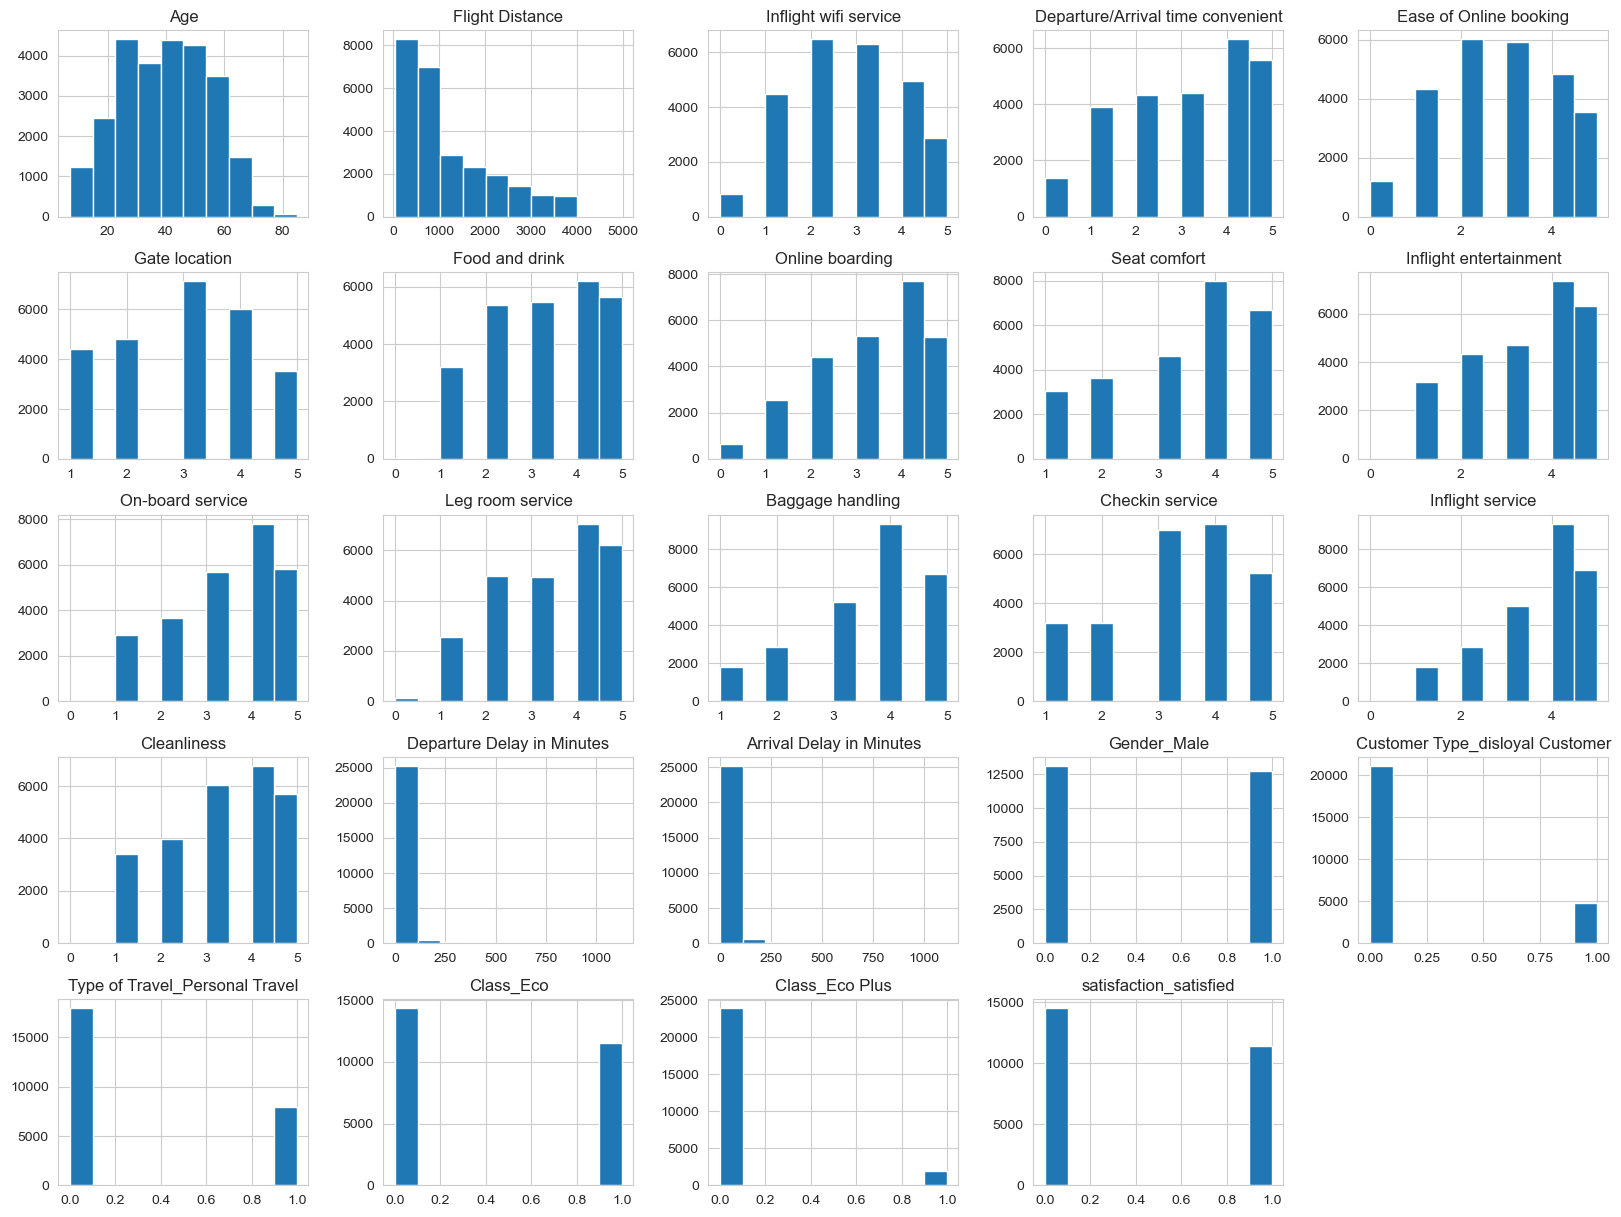

In [63]:
_ = df_new.hist(figsize=(20,15))

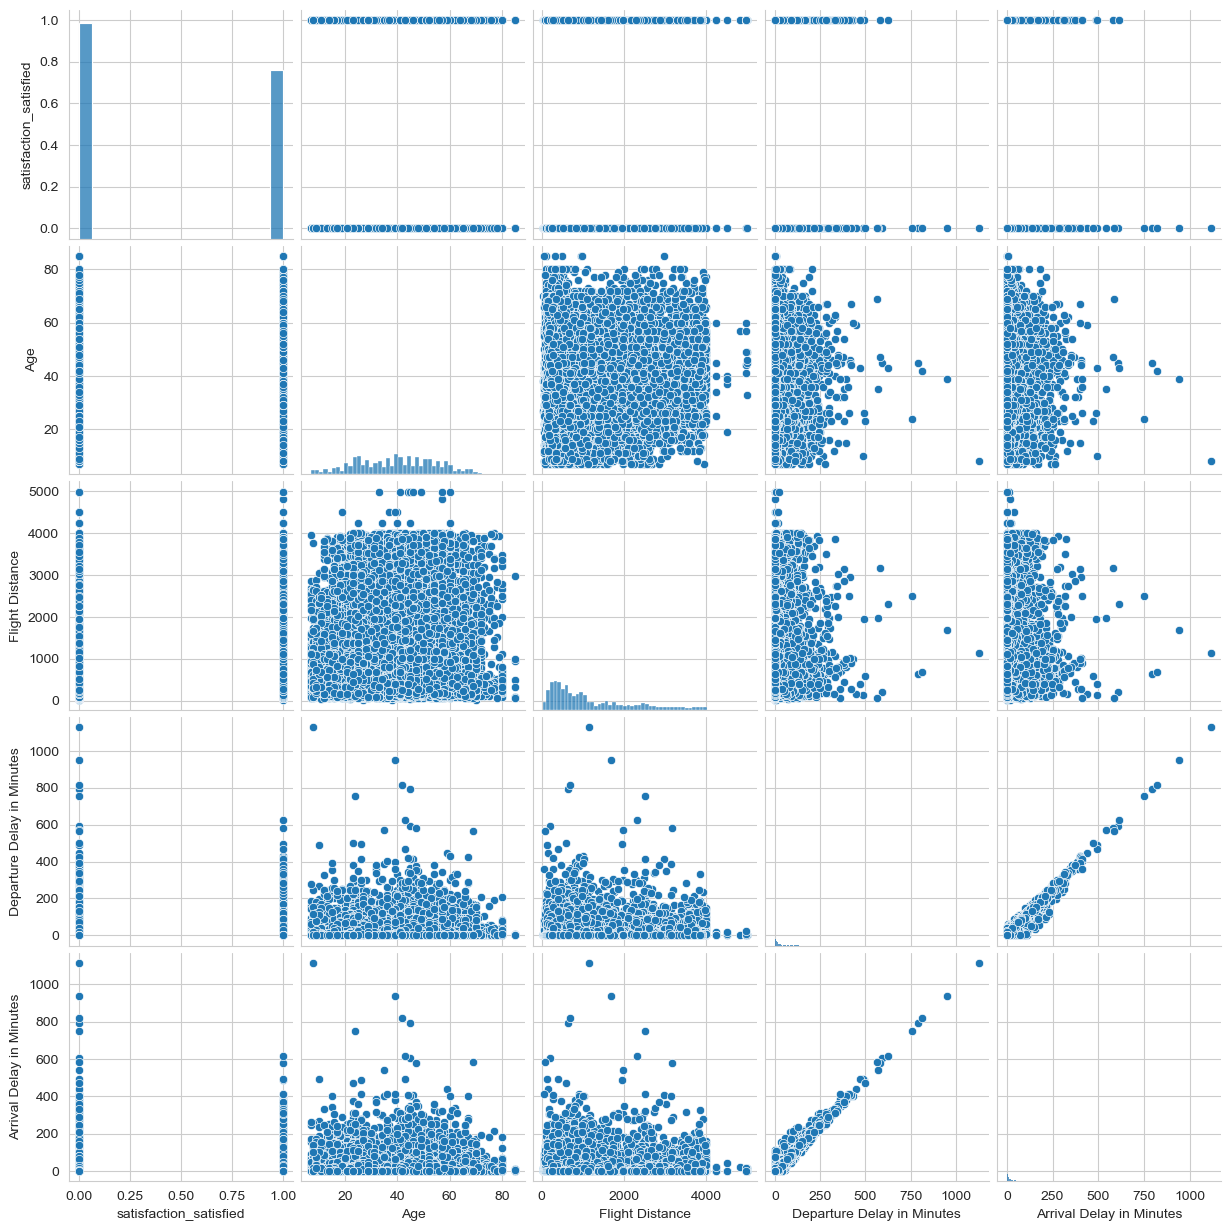

In [64]:
sns.pairplot(data = df_new.loc[:,['satisfaction_satisfied'] +columns_numerical])
plt.show()

###### split data into train and test

In [65]:
df_new.head(3)

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,52,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,0,0,0,1,0,1
1,36,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,0,0,0,0,0,1
2,20,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,1,1,0,1,0,0


In [66]:
df_new.columns

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus',
       'satisfaction_satisfied'],
      dtype='object')

In [67]:
X = df_new.drop(columns='satisfaction_satisfied')
y =df_new[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (18125, 23)
X_test.shape: (7768, 23)
y_train.shape: (18125,)
y_test.shape: (7768,)


scale train & test data by standardScaler()

In [68]:

# Create an instance of StandardScaler
scaler = StandardScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled)

[[ 0.75076181  0.3959149   0.20875799 ... -0.66417067 -0.89967993
  -0.28186402]
 [-0.69898188 -0.42342302 -1.29094019 ... -0.66417067 -0.89967993
  -0.28186402]
 [ 1.93691574 -1.09870153  1.70845616 ...  1.50563709  1.1115064
  -0.28186402]
 ...
 [ 1.47563365 -0.18032276 -1.29094019 ...  1.50563709  1.1115064
  -0.28186402]
 [ 0.75076181  2.39874094  0.20875799 ... -0.66417067 -0.89967993
  -0.28186402]
 [-1.81923836 -0.09828892  0.20875799 ...  1.50563709  1.1115064
  -0.28186402]]


### 2. Logistic Regression ----------------------------------------------------------------------------------------------------------

In [69]:
logitReg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', random_state=42)
logitReg.fit(X_train_scaled, y_train)

LogisticRegression(C=1e+42, random_state=42, solver='liblinear')

In [70]:
# Print the results and some evaluation criteria

pd.set_option('display.max_columns', None)  # Display all columns

# Print intercept
print('Intercept:', logitReg.intercept_[0])

# Create a DataFrame to store coefficients
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': logitReg.coef_[0]})

# Print coefficients
print(coefficients)

# Calculate and print AIC
AIC = AIC_score(y_test, logitReg.predict(X_test_scaled), df=len(X_train.columns) + 1)
print('AIC:', AIC)


Intercept: -0.48937343198024713
                             Variable  Coefficient
0                                 Age    -0.136325
1                     Flight Distance    -0.026604
2               Inflight wifi service     0.575022
3   Departure/Arrival time convenient    -0.253709
4              Ease of Online booking    -0.273508
5                       Gate location     0.020744
6                      Food and drink    -0.021382
7                     Online boarding     0.825788
8                        Seat comfort     0.035960
9              Inflight entertainment     0.116550
10                   On-board service     0.388497
11                   Leg room service     0.311282
12                   Baggage handling     0.173492
13                    Checkin service     0.457561
14                   Inflight service     0.124741
15                        Cleanliness     0.276398
16         Departure Delay in Minutes     0.118886
17           Arrival Delay in Minutes    -0.343700

Predictors with Negative Coefficients are Age, Flight Distance, Departure/Arrival Time Convenience, Ease of Online Booking,Food and Drink, Arrival Delay in Minutes,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco and Class_Eco Plus.

A one-unit increase in age is associated with a decrease in the log-odds of satisfaction by approximately 0.136. However, it's important to note that the effect of age on satisfaction may be small based on this coefficient.

Besides Age, all other factors are associated with slightly lower satisfaction levels. the less convenient/ease or lower rating are less likely to be satisfied. Especially for the Type of Travel_Personal Travel, Choosing personal travel is associated with a decrease in the log-odds of satisfaction by approximately 1.296.This suggests that passengers traveling for personal reasons are less likely to be satisfied compared to passengers traveling for other purposes.

Customer Type_disloyal Customer: Being a disloyal customer (as indicated by the dummy variable) is associated with a decrease in the log-odds of satisfaction by approximately 0.792. This suggests that loyal customers are more likely to be satisfied compared to disloyal customers



Predictors with Positive Coefficient are:Inflight WiFi Service,Inflight entertainment,Online Boarding, Seat Comfort,On-board Service,Cleanliness,Gate location,Leg room service,  Baggage handling,Checkin service, and Inflight service. 

All these factors are positively affect customer satisfaction, the better services are, the more likely to be satisfied. Especially for Inflight WiFi Service(0.575022 ),Online Boarding(0.825788), and Checkin service(0.457561) are associated with higher increase in the log-odds of satisfaction.


###### Evaluate the model

In [71]:
classificationSummary(y_train, logitReg.predict(X_train_scaled))
classificationSummary(y_test, logitReg.predict(X_test_scaled))

Confusion Matrix (Accuracy 0.8723)

       Prediction
Actual    0    1
     0 9221  995
     1 1319 6590
Confusion Matrix (Accuracy 0.8673)

       Prediction
Actual    0    1
     0 3850  462
     1  569 2887


In [72]:
regressionSummary(y_train, logitReg.predict(X_train_scaled))
regressionSummary(y_test, logitReg.predict(X_test_scaled))


Regression statistics

               Mean Error (ME) : 14.0714
Root Mean Squared Error (RMSE) : 0.3573
     Mean Absolute Error (MAE) : 14.0714

Regression statistics

               Mean Error (ME) : 15.2393
Root Mean Squared Error (RMSE) : 0.3643
     Mean Absolute Error (MAE) : 15.2393


In [73]:
y_pred = logitReg.predict(X_test_scaled)
y_pred_proba = logitReg.predict_proba(X_test_scaled) 
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"precision_score: {precision_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba[:,1])}")

accuracy_score: 0.8672760041194645
precision_score: 0.8620483726485518
recall_score: 0.8353587962962963
f1_score: 0.8484937545922117
roc_auc_score: 0.9239902479299802


According to the confustion matrix, in both the training and test sets, the model seems to have higher accuracy(87% on training data and 86% on test data) in predicting class 0 (satisfaction not satisfied) compared to class 1 (satisfaction satisfied). 

According to Regression statistics, the difference between the RMSE and MAE values of the training and test sets is relatively small (0.01), we can say that the model does not exhibit significant signs of overfitting.

Overall, the logistic regression model achieves high accuracy(86.7%),indicating that it correctly predicts customer satisfaction status in 86.73% of the cases.

The precision(86.2%) and recall(83.5%) indicates that out of all the cases the model predicted as satisfied, approximately 86.2% are indeed satisfied. and the model correctly identifies around 83.5% of the satisfied customers.

F1 score(0.848) tells a reasonable balance between precision and recall, taking into account both the false positives and false negatives.

The relatively high ROC AUC score(0.924) indicates the model has a good discriminatory power and performs well in differentiating between satisfied and unsatisfied customers.

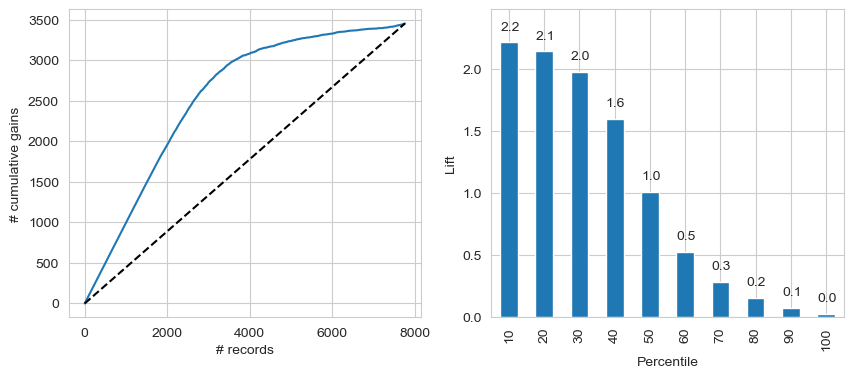

In [74]:
logit_reg_pred = logitReg.predict(X_test_scaled)
logit_reg_proba = logitReg.predict_proba(X_test_scaled)
logit_result = pd.DataFrame({'actual': y_test,
'p(0)': [p[0] for p in logit_reg_proba],
'p(1)': [p[1] for p in logit_reg_proba],
'predicted': logit_reg_pred })


df1 = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df1.actual, ax=axes[0])
liftChart(df1['p(1)'], title=False, ax=axes[1])
plt.show()



According to the gains chart above, there are approximatly 3300 responses satisfed with airline given 4000 customers contacted via survey.

According to the Lift chart, If we took 10% of the data based on our model, we would expect to find 2.2 times the number of success than at random.

### 841 Operation visualization ----------------------------------------------------------------------------------------------------------

In [75]:
TARGET = 'satisfaction_satisfied'
Negative_vars = ['Age','Flight Distance','Departure/Arrival time convenient', 'Ease of Online booking','Customer Type_disloyal Customer', 'Food and drink', 'Arrival Delay in Minutes','Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus']

Positive_vars = ['Inflight entertainment', 'On-board service', 'Leg room service', 'Inflight WiFi Service','Baggage handling', 'Checkin service', 'Inflight service', 'Online boarding', 'Seat comfort','Gate location', 'Cleanliness', 'Gender_Male', 'Departure Delay in Minutes']

df.describe()


,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25893.000000
mean,12987.500000,65005.657992,39.620958,1193.788459,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.740857
std,7498.769632,37611.526647,15.135685,998.683999,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.517539
min,0.000000,17.000000,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,6493.750000,32170.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000
50%,12987.500000,65319.500000,40.000000,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000
75%,19481.250000,97584.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000
max,25975.000000,129877.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000


/var/folders/t2/3bq3v00n6gxcll9sx01kdxpc0000gn/T/ipykernel_58625/522866934.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<Axes: >

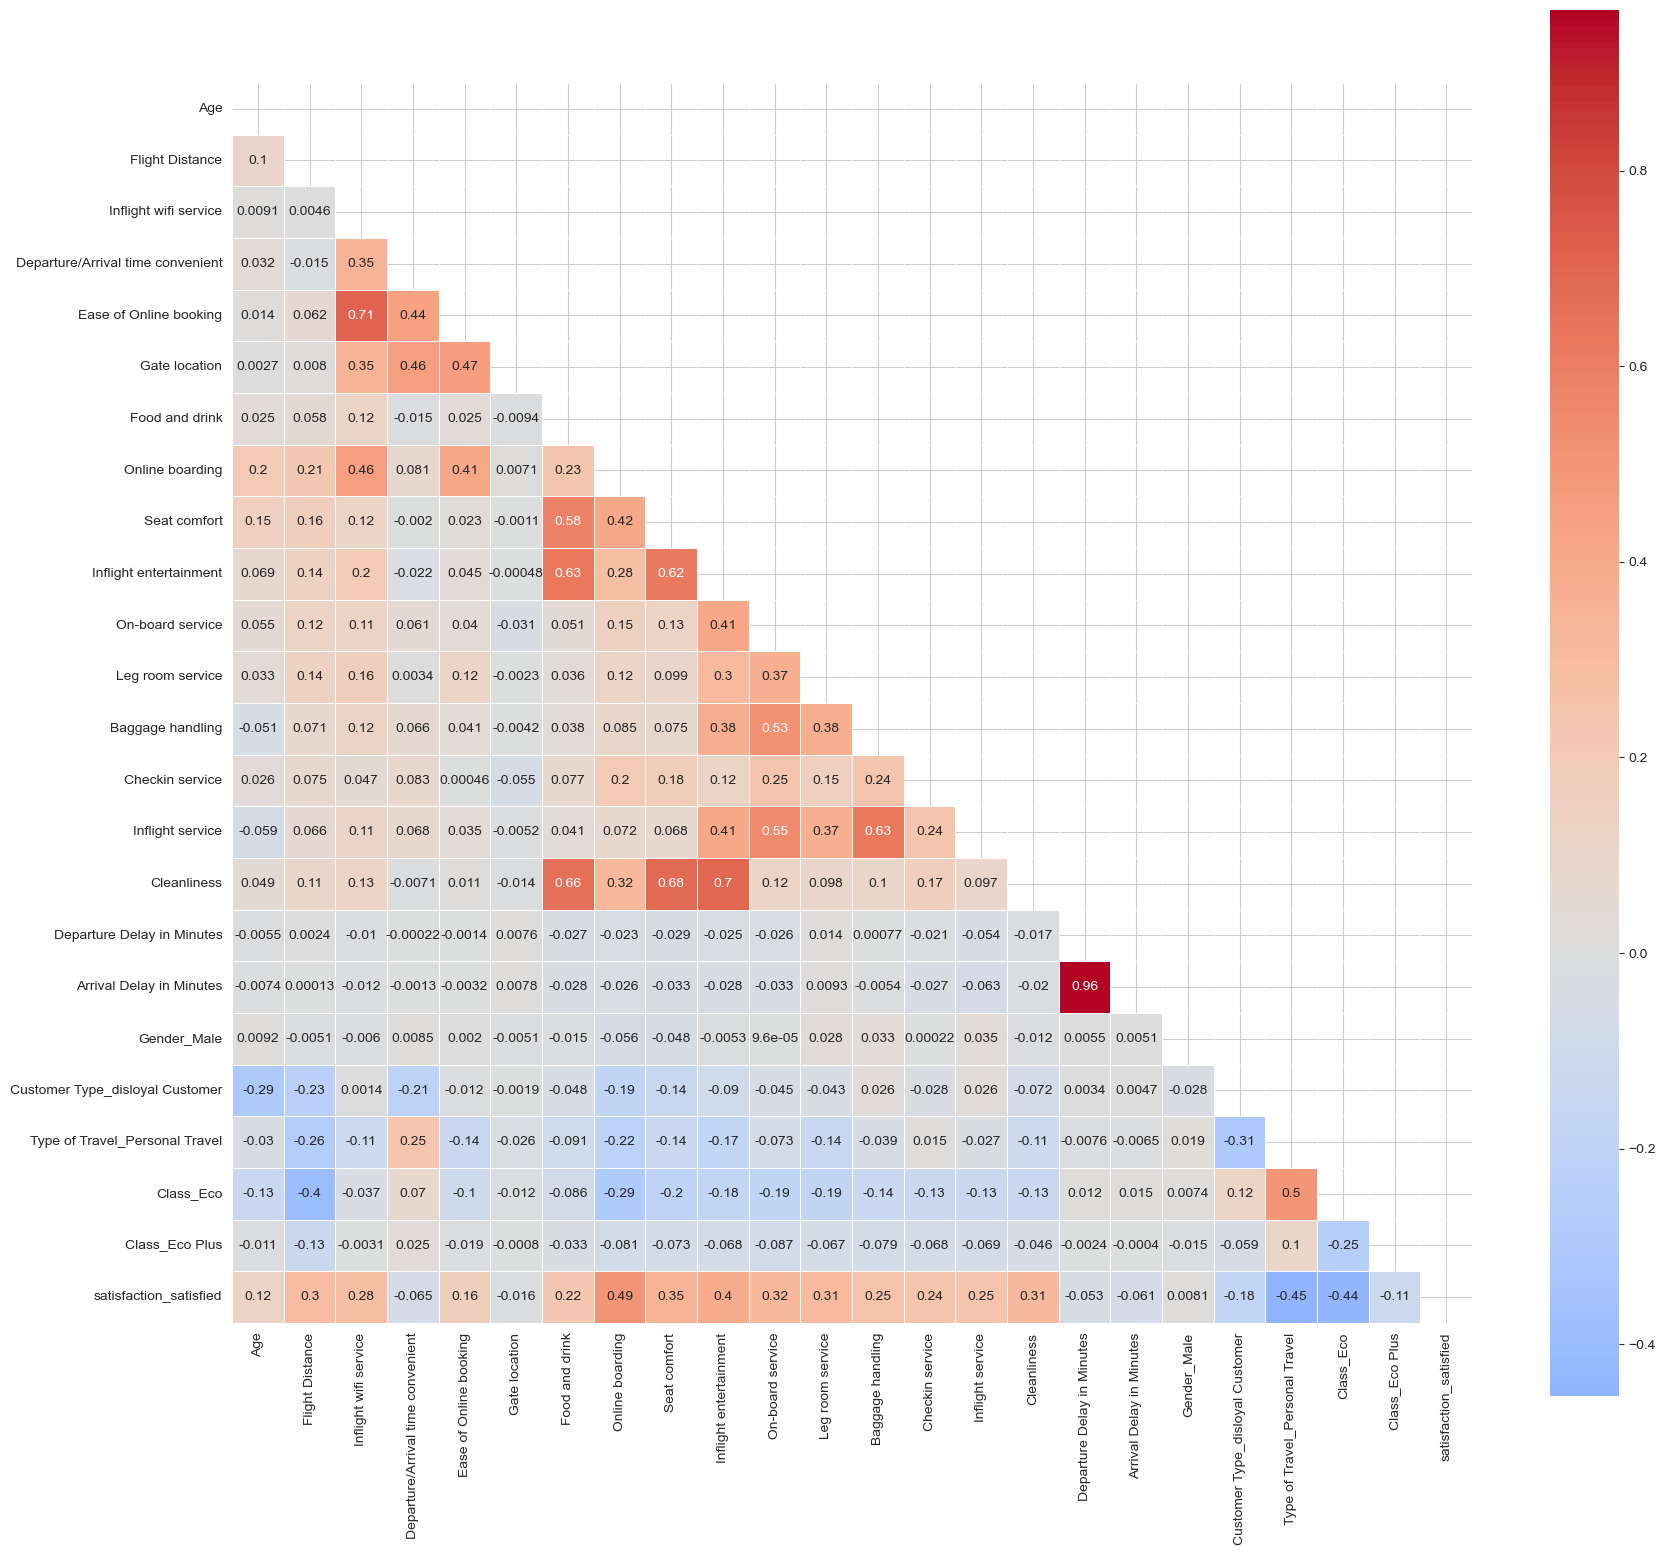

In [76]:
corr = df_new.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("coolwarm", as_cmap=True)  
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})


In [77]:
columns_ordinal =['Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']

In [78]:
df_new[columns_ordinal].mean().sort_values(ascending = False)

Inflight service                     3.648824
Baggage handling                     3.632681
Seat comfort                         3.448886
On-board service                     3.385587
Inflight entertainment               3.356969
Leg room service                     3.349786
Checkin service                      3.313907
Cleanliness                          3.285521
Online boarding                      3.261615
Food and drink                       3.214923
Departure/Arrival time convenient    3.046422
Gate location                        2.976442
Ease of Online booking               2.755996
Inflight wifi service                2.723709
dtype: float64

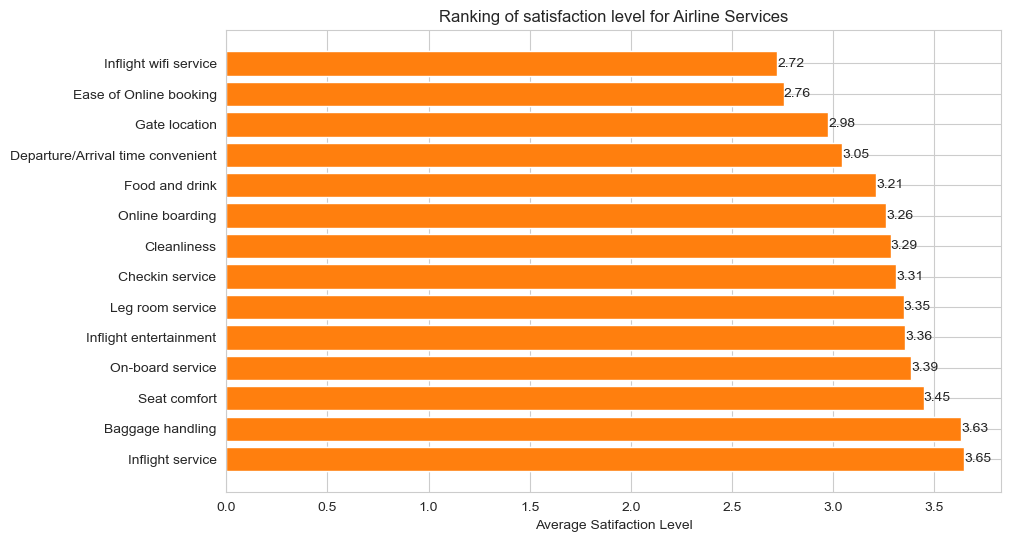

In [79]:
mean_values = df_new[columns_ordinal].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(mean_values.index, round(mean_values,2))

bars = plt.barh(mean_values.index, mean_values)

plt.xlabel('Average Satifaction Level')
plt.title('Ranking of satisfaction level for Airline Services')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, round(bar.get_width(), 2), ha='left', va='center')
    
plt.show()

According to the logistic regression model, several factors are positively correlated with customer satisfaction, including Inflight wifi service, Ease of online booking, Online Boarding, and Checkin service. Among these factors, Online Boarding stands out as particularly important. Customers highly value a seamless and hassle-free online boarding experience, encompassing easy access to boarding passes, clear instructions, and minimal delays. Airlines that prioritize optimizing their online boarding process are likely to achieve higher levels of customer satisfaction.

Analyzing the chart, we observe that our performance is commendable in terms of inflight service and baggage handling, with satisfaction levels exceeding 3.5 out of 5. However, there is significant room for improvement in areas such as inflight wifi service, ease of online booking, and gate location, as indicated by lower satisfaction levels below 3. These areas present opportunities for us to enhance customer satisfaction and further refine the overall travel experience.

It is noteworthy that both "Food and drink" and "Online boarding" play pivotal roles in shaping the overall customer experience during air travel. Therefore, focusing on providing high-quality food and drink options, as well as optimizing the online boarding process, can lead to enhanced customer satisfaction levels. By committing to these improvements, we can differentiate ourselves in the industry and gain a competitive edge, ultimately fostering greater customer loyalty and satisfaction."

In [80]:
df_new['Arrival Delay in Minutes'].count()

25893

In [81]:
conditions =[df_new['Arrival Delay in Minutes']>=14,df_new['Arrival Delay in Minutes']<14]
values =['>=14 minutes','<14 minutes']

# Apply the conditions using numpy.select()
df_new['Arrival_Delay'] = np.select(conditions, values)

# Display the DataFrame
df_new.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied,Arrival_Delay
0,52,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,0,0,0,1,0,1,>=14 minutes
1,36,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,0,0,0,0,0,1,<14 minutes
2,20,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,1,1,0,1,0,0,<14 minutes
3,44,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,0,0,0,0,1,<14 minutes
4,49,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,0,0,0,1,0,1,>=14 minutes


In [82]:
df2= df_new.groupby('Arrival_Delay')[columns_ordinal].mean().round(2)
df2

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
Arrival_Delay,,,,,,,,,,,,,,
<14 minutes,2.74,3.04,2.76,2.96,3.24,3.29,3.48,3.39,3.42,3.36,3.65,3.34,3.68,3.31
>=14 minutes,2.68,3.05,2.76,3.02,3.15,3.18,3.36,3.27,3.29,3.31,3.58,3.25,3.54,3.21


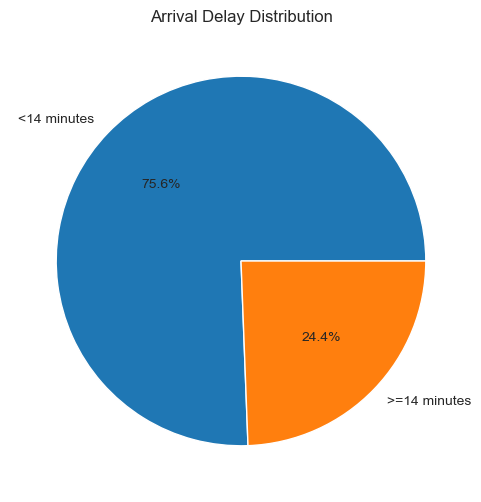

In [83]:
counts = df_new.groupby('Arrival_Delay')[TARGET].count()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Arrival Delay Distribution')
plt.show()

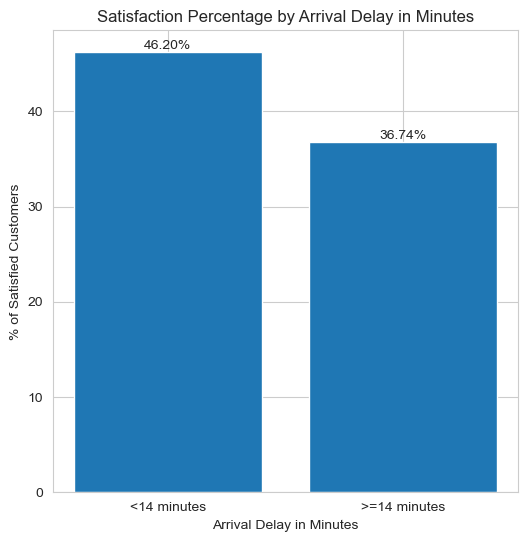

In [84]:

# Calculate the percentage of satisfied customers for each category
satisfied_counts = df_new.groupby('Arrival_Delay')[TARGET].sum()
total_counts = df_new.groupby('Arrival_Delay')[TARGET].count()
percent_satisfied = (satisfied_counts / total_counts) * 100

# Create the bar chart
plt.figure(figsize=(6, 6))
plt.bar(percent_satisfied.index, percent_satisfied)
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('% of Satisfied Customers')
plt.title('Satisfaction Percentage by Arrival Delay in Minutes')
# Add data labels to the bars
for i, v in enumerate(percent_satisfied):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')
plt.show()



In [85]:
conditions = [
    (df_new['Arrival Delay in Minutes'] > 14),
    ((df_new['Arrival Delay in Minutes'] >= 5) & (df_new['Arrival Delay in Minutes'] <= 14)),
    (df_new['Arrival Delay in Minutes'] < 5)
]
values = ['>=14 minutes', '5-14 minutes', 'less than 5 minutes']

# Apply the conditions using numpy.select()
df_new['Arrival_Delay'] = np.select(conditions, values, default='Unknown')

# Display the DataFrame
df_new1=df_new
df_new1.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied,Arrival_Delay
0,52,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,0,0,0,1,0,1,>=14 minutes
1,36,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,0,0,0,0,0,1,less than 5 minutes
2,20,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,1,1,0,1,0,0,less than 5 minutes
3,44,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,0,0,0,0,1,5-14 minutes
4,49,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,0,0,0,1,0,1,>=14 minutes


In [86]:
counts1 = df_new1.groupby('Arrival_Delay')[TARGET].count()

counts1

Arrival_Delay
5-14 minutes            3172
>=14 minutes            6112
less than 5 minutes    16609
Name: satisfaction_satisfied, dtype: int64

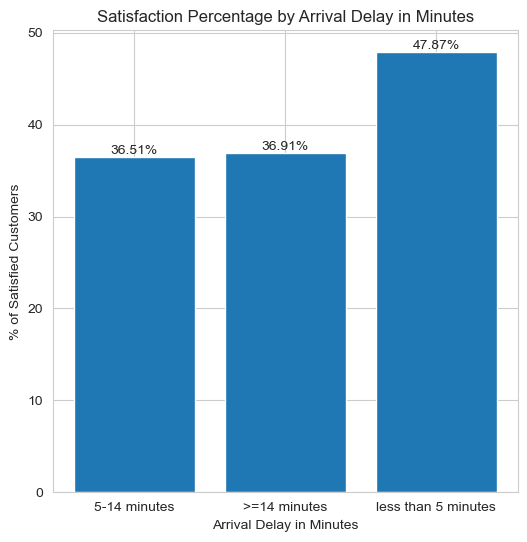

In [87]:
# Calculate the percentage of satisfied customers for each category
satisfied_counts = df_new1.groupby('Arrival_Delay')[TARGET].sum()
total_counts = df_new1.groupby('Arrival_Delay')[TARGET].count()
percent_satisfied = (satisfied_counts / total_counts) * 100

# Create the bar chart
plt.figure(figsize=(6, 6))
plt.bar(percent_satisfied.index, percent_satisfied)
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('% of Satisfied Customers')
plt.title('Satisfaction Percentage by Arrival Delay in Minutes')
# Add data labels to the bars
for i, v in enumerate(percent_satisfied):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')
plt.show()

In [88]:
conditions = [
    (df_new1['Departure Delay in Minutes'] > 14),
    ((df_new1['Departure Delay in Minutes'] >= 5) & (df_new1['Departure Delay in Minutes'] <= 14)),
    (df_new1['Departure Delay in Minutes'] < 5)
]
values = ['>=14 minutes', '5-14 minutes', 'less than 5 minutes']

# Apply the conditions using numpy.select()
df_new1['Departure_Delay'] = np.select(conditions, values, default='Unknown')

# Display the DataFrame
df_new1.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied,Arrival_Delay,Departure_Delay
0,52,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,0,0,0,1,0,1,>=14 minutes,>=14 minutes
1,36,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,0,0,0,0,0,1,less than 5 minutes,less than 5 minutes
2,20,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,1,1,0,1,0,0,less than 5 minutes,less than 5 minutes
3,44,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,0,0,0,0,1,5-14 minutes,less than 5 minutes
4,49,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,0,0,0,1,0,1,>=14 minutes,less than 5 minutes


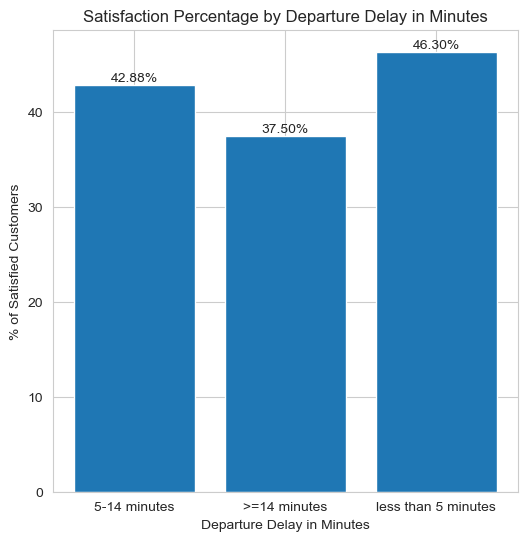

In [89]:
# Calculate the percentage of satisfied customers for each category
satisfied_counts = df_new1.groupby('Departure_Delay')[TARGET].sum()
total_counts = df_new1.groupby('Departure_Delay')[TARGET].count()
percent_satisfied = (satisfied_counts / total_counts) * 100

# Create the bar chart
plt.figure(figsize=(6, 6))
plt.bar(percent_satisfied.index, percent_satisfied)
plt.xlabel('Departure Delay in Minutes')
plt.ylabel('% of Satisfied Customers')
plt.title('Satisfaction Percentage by Departure Delay in Minutes')
# Add data labels to the bars
for i, v in enumerate(percent_satisfied):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')
plt.show()

Based on the two charts provided, it is evident that customer satisfaction is significantly influenced by arrival delays. Customers are more likely to be satisfied if the arrival delay is less than 5 minutes. However, if the delay exceeds 5 minutes and extends up to 14 minutes or more, the satisfaction level remains relatively stable. Conversely, when it comes to departure delays, customers display a different pattern of reaction and exhibit a higher tolerance. Although the highest proportion of satisfaction is observed when the departure delay is within 5 minutes, there is only a slight decline in satisfaction for delays between 5 and 14 minutes. However, once the departure delay reaches or surpasses 14 minutes, the percentage of satisfied customers experiences a notable decrease 

In [90]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [91]:
df_cat=df.drop(['Unnamed: 0', 'id'], axis=1).dropna()
df_cat.shape

(25893, 23)

In [92]:
df_cat = pd.get_dummies(df_cat, columns = ['satisfaction'], drop_first =True)
df_cat.head()


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction_satisfied
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,1
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,1
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,0
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,1


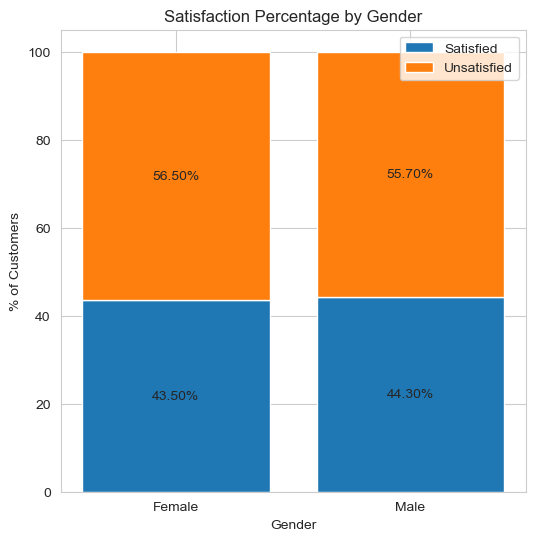

In [93]:
def category_chart(var):
    satisfied_counts = df_cat.groupby(var)['satisfaction_satisfied'].sum()
    unsatisfied_counts = df_cat.groupby(var)['satisfaction_satisfied'].count() - satisfied_counts
    total_counts = df_cat.groupby(var)['satisfaction_satisfied'].count()
    
    percent_satisfied = (satisfied_counts / total_counts) * 100
    percent_unsatisfied = (unsatisfied_counts / total_counts) * 100
    
    # create the stacked bar chart
    plt.figure(figsize=(6, 6))
    plt.bar(percent_satisfied.index, percent_satisfied, label='Satisfied')
    plt.bar(percent_unsatisfied.index, percent_unsatisfied, bottom=percent_satisfied, label='Unsatisfied')
    
    plt.xlabel(var)
    plt.ylabel('% of Customers')
    plt.title('Satisfaction Percentage by {}'.format(var))
    
    for i, (satisfied, unsatisfied) in enumerate(zip(percent_satisfied, percent_unsatisfied)):
        plt.text(i, satisfied/2, f'{satisfied:.2f}%', ha='center', va='center')
        plt.text(i, satisfied + unsatisfied/2, f'{unsatisfied:.2f}%', ha='center', va='center')
    
    plt.legend(loc='upper right')
   
    plt.show()

category_chart('Gender')



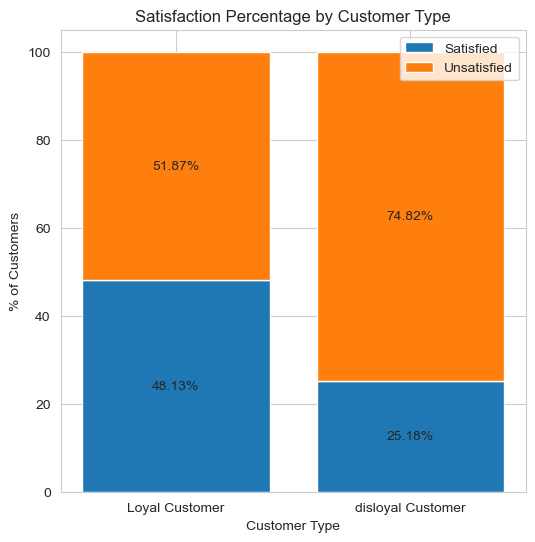

In [94]:
category_chart('Customer Type')

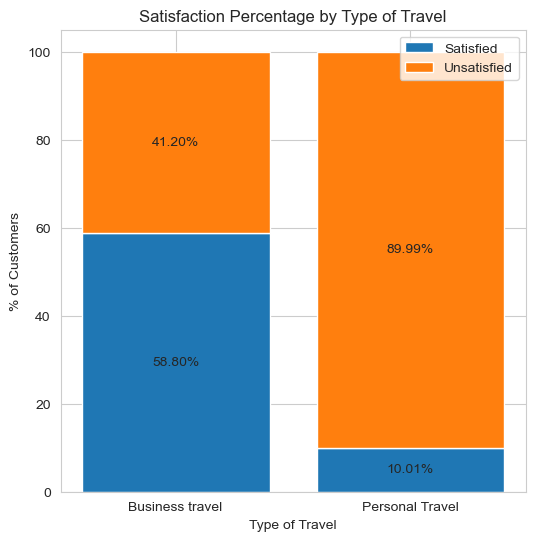

In [95]:
category_chart('Type of Travel')

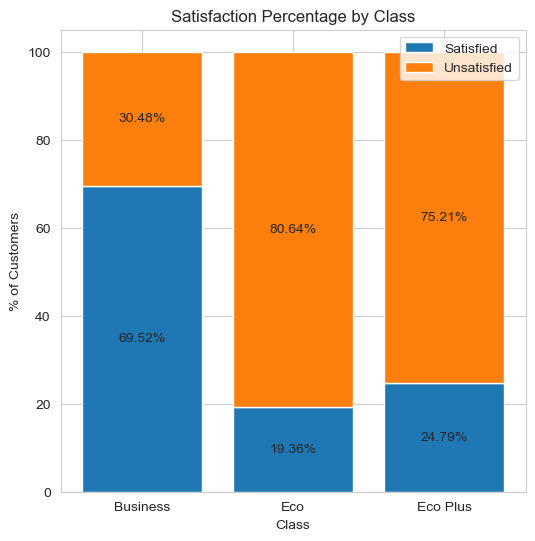

In [96]:
category_chart('Class')

Based on the charts, the gender does not exhibit a significant impact on customer satisfaction. However,Customers in the Business class demonstrate a higher level of satisfaction compared to those in the Eco and Eco Plus classes. Additionally, when contrasting business-related travel with personal travel, the former tends to result in a greater likelihood of customer satisfaction.

Furthermore, the analysis suggests that loyal customers exhibit a higher percentage of satisfaction in comparison to disloyal customers.

In [97]:
df_cat.groupby('Type of Travel')['satisfaction_satisfied'].count()

Type of Travel
Business travel    17980
Personal Travel     7913
Name: satisfaction_satisfied, dtype: int64

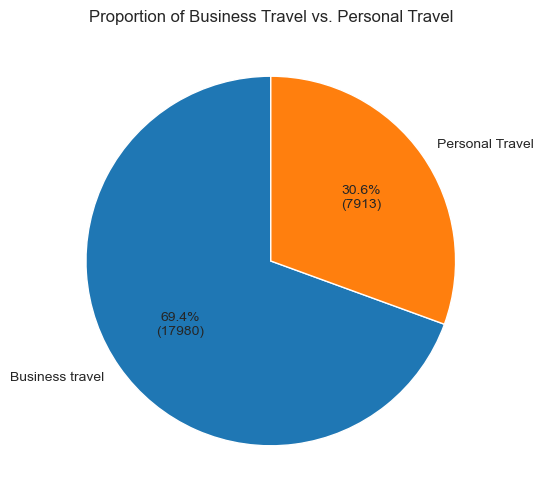

In [98]:
travel_counts = df_cat.groupby('Type of Travel')['satisfaction_satisfied'].count()

plt.figure(figsize=(8, 6))

# Create a pie chart
plt.pie(travel_counts, labels=travel_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(travel_counts))})",
        startangle=90)

plt.title('Proportion of Business Travel vs. Personal Travel')

plt.show()



Based on the analysis, it is evident that business travel constitutes a significant portion, accounting for nearly 70% of our customer base. This finding emphasizes the importance of prioritizing our services and optimizing the airline operation system to cater to the specific needs and expectations of business travelers.

To effectively optimize our airline operation system for business travel, we can consider the following strategies:

Streamline check-in and boarding processes: By implementing seamless and expedited check-in procedures, such as dedicated counters or online check-in options, we can enhance the overall travel experience and minimize any potential stress or delays.

Enhance in-flight services: Business travelers often utilize flight time for work and productivity. Offering reliable and high-speed inflight wifi service is crucial to meet their connectivity needs. Additionally, providing comfortable seating, ample legroom, and attentive cabin crew can further enhance their experience and productivity during the flight.

Focus on business amenities: Consider incorporating amenities that cater specifically to business travelers, such as dedicated workspaces, power outlets, and USB ports at seating areas, allowing them to stay connected and productive throughout their journey.

Collaborate with corporate clients: By understanding their travel needs and preferences, we can tailor our services to align with their requirements, offering corporate travel programs, incentives, and exclusive benefits. This collaboration can contribute to increased customer satisfaction and loyalty among business travelers.

### 3. Decision Tree ----------------------------------------------------------------------------------------------------------


In [99]:
df_new.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied,Arrival_Delay,Departure_Delay
0,52,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,0,0,0,1,0,1,>=14 minutes,>=14 minutes
1,36,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,0,0,0,0,0,1,less than 5 minutes,less than 5 minutes
2,20,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,1,1,0,1,0,0,less than 5 minutes,less than 5 minutes
3,44,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,0,0,0,0,1,5-14 minutes,less than 5 minutes
4,49,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,0,0,0,1,0,1,>=14 minutes,less than 5 minutes


In [100]:
dtc = DecisionTreeClassifier()

In [101]:
param={
    'max_depth':[1,2,3,4,5,6],
    'criterion':['gini','entropy'],
    'min_samples_leaf':[10,20,50,60],
    'min_samples_split': [50,60,70,80,90,100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005]
}

cv=GridSearchCV(dtc,param_grid=param,n_jobs=-1)
cv.fit(X_train,y_train)

print('Initial score: ', cv.best_score_)
print('Initial parameters: ', cv.best_params_)

Initial score:  0.9191172413793105
Initial parameters:  {'criterion': 'entropy', 'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_leaf': 10, 'min_samples_split': 70}


[Text(0.4363425925925926, 0.9285714285714286, 'Online boarding <= 3.5\nentropy = 0.988\nsamples = 18125\nvalue = [10216, 7909]\nclass = Neutral/Dissatisfied'),
 Text(0.11342592592592593, 0.7857142857142857, 'Inflight wifi service <= 0.5\nentropy = 0.621\nsamples = 9126\nvalue = [7717, 1409]\nclass = Neutral/Dissatisfied'),
 Text(0.037037037037037035, 0.6428571428571429, 'Departure Delay in Minutes <= 77.5\nentropy = 0.029\nsamples = 339\nvalue = [1, 338]\nclass = Satisfied'),
 Text(0.018518518518518517, 0.5, 'entropy = 0.0\nsamples = 329\nvalue = [0, 329]\nclass = Satisfied'),
 Text(0.05555555555555555, 0.5, 'entropy = 0.469\nsamples = 10\nvalue = [1, 9]\nclass = Satisfied'),
 Text(0.18981481481481483, 0.6428571428571429, 'Inflight wifi service <= 3.5\nentropy = 0.535\nsamples = 8787\nvalue = [7716, 1071]\nclass = Neutral/Dissatisfied'),
 Text(0.09259259259259259, 0.5, 'Type of Travel_Personal Travel <= 0.5\nentropy = 0.351\nsamples = 7929\nvalue = [7405, 524]\nclass = Neutral/Dissatis

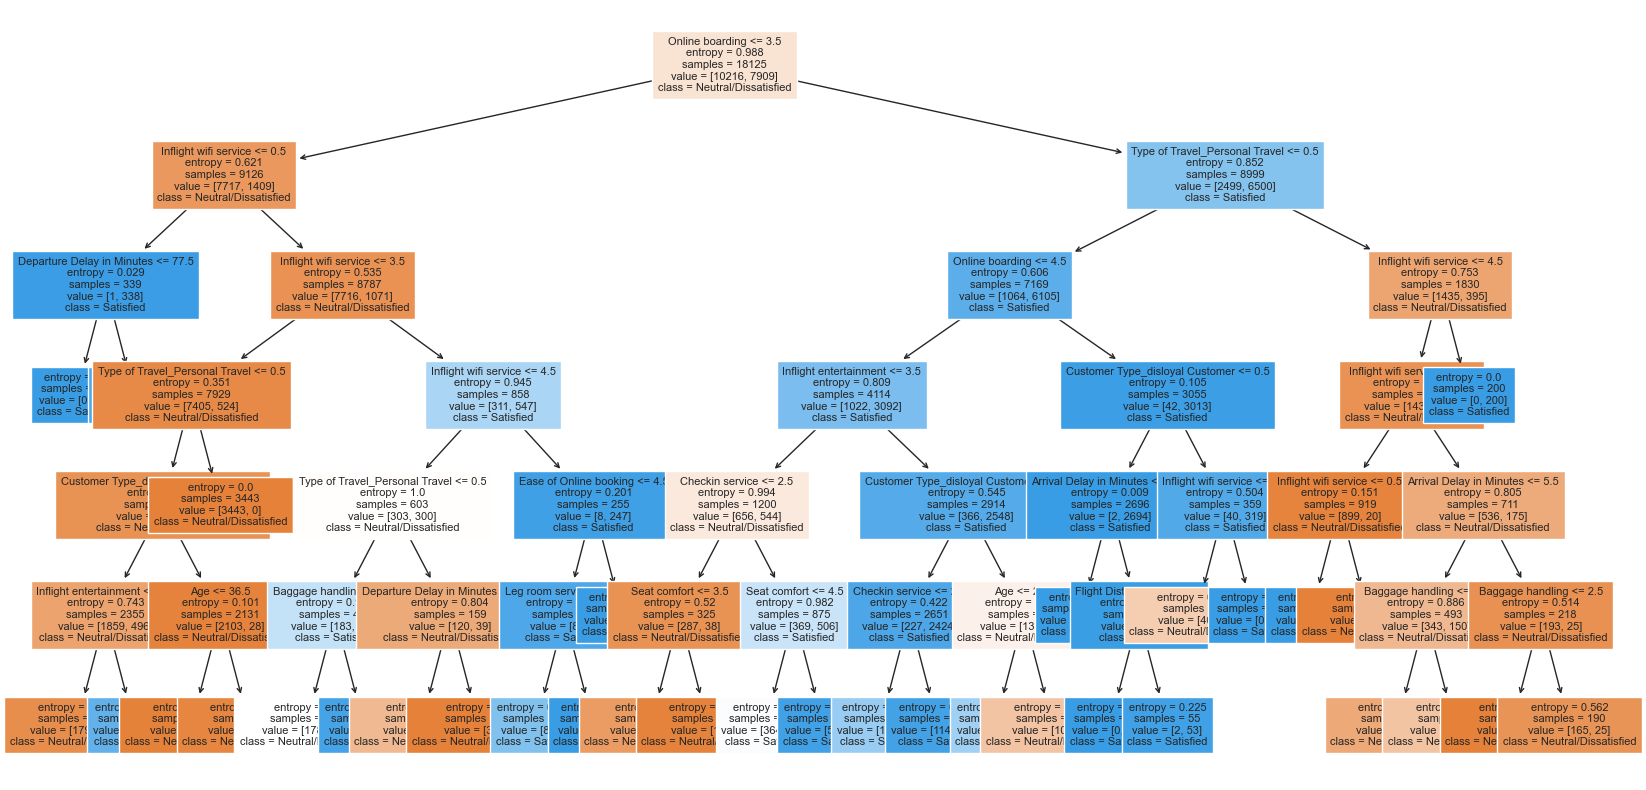

In [102]:
%matplotlib inline

#train a very simple model
tree_1 = DecisionTreeClassifier(random_state=0, max_depth=6, criterion='entropy',min_samples_leaf=10, min_impurity_decrease=0,
                                min_samples_split=70) #max_depth limits the tree to one split
tree_1.fit(X_train, y_train)

#let's plot it
fig, axe = plt.subplots(figsize=(20,10))

plot_tree( tree_1, ax = axe, feature_names=X_train.columns,  
                   class_names=['Neutral/Dissatisfied', 'Satisfied'],
                      filled=True, fontsize=8
                   )



In [103]:


classificationSummary(y_train, tree_1.predict(X_train))
classificationSummary(y_test, tree_1.predict(X_test))

Confusion Matrix (Accuracy 0.9209)

       Prediction
Actual    0    1
     0 9503  713
     1  720 7189
Confusion Matrix (Accuracy 0.9159)

       Prediction
Actual    0    1
     0 4009  303
     1  350 3106


In [104]:
# calcuate precision and recall on the train data
tp = 7189
fp = 713
tn = 9503
fn = 720 
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision on trained data is %1.2f and it's recall is %1.2f" % (prc, rec))

Model's precision on trained data is 0.91 and it's recall is 0.91


In [105]:
# calcuate precision and recall on the test data
tp = 3106
fp = 303
tn = 4009
fn = 350 
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision on trained data is %1.2f and it's recall is %1.2f" % (prc, rec))

Model's precision on trained data is 0.91 and it's recall is 0.90


In [106]:
from sklearn.tree import export_text
tree_rules = export_text(tree_1, feature_names=X_train.columns.tolist())
print(tree_rules)

|--- Online boarding <= 3.50
|   |--- Inflight wifi service <= 0.50
|   |   |--- Departure Delay in Minutes <= 77.50
|   |   |   |--- class: 1
|   |   |--- Departure Delay in Minutes >  77.50
|   |   |   |--- class: 1
|   |--- Inflight wifi service >  0.50
|   |   |--- Inflight wifi service <= 3.50
|   |   |   |--- Type of Travel_Personal Travel <= 0.50
|   |   |   |   |--- Customer Type_disloyal Customer <= 0.50
|   |   |   |   |   |--- Inflight entertainment <= 3.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Inflight entertainment >  3.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Customer Type_disloyal Customer >  0.50
|   |   |   |   |   |--- Age <= 36.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Age >  36.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Type of Travel_Personal Travel >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Inflight wifi service >  3.50
|   |   |   |--- Inflight wifi service <= 4.50
|   | 

#LEFT BRANCH TREE
IF (Online boarding <= 3.50) AND (Inflight wifi service <= 0.50) AND (Departure Delay in Minutes <= 77.50) THEN SATISFIED
IF (Online boarding <= 3.50) AND (Inflight wifi service <= 0.50) AND (Departure Delay in Minutes > 77.50) THEN SATISFIED
PRUNED to
1) IF (Online boarding <= 3.50) AND (Inflight wifi service <= 0.50) THEN SATISFIED

2) IF (Online boarding <= 3.50) AND (Inflight wifi service > 0.50 AND Inflight wifi service <= 3.50) AND (Departure Delay in Minutes > 77.50) AND (Type of Travel_Personal Travel <= 0.50) AND ( Customer Type_disloyal Customer <= 0.50) AND (Inflight entertainment <= 3.50) THEN Neutral/Dissatisfied

3) IF (Online boarding <= 3.50) AND (Inflight wifi service > 0.50 AND Inflight wifi service <= 3.50) AND (Departure Delay in Minutes > 77.50) AND (Type of Travel_Personal Travel <= 0.50) AND ( Customer Type_disloyal Customer <= 0.50) AND (Inflight entertainment > 3.50) THEN Satisfied

4) IF (Online boarding <= 3.50) AND (Inflight wifi service > 0.50 AND Inflight wifi service <= 3.50) AND (Departure Delay in Minutes > 77.50) AND (Type of Travel_Personal Travel <= 0.50) AND ( Customer Type_disloyal Customer > 0.50) THEN Neutral/Dissatisfied
#PRUNED AGE criteria

5) IF (Online boarding <= 3.50) AND (Inflight wifi service > 0.50 AND Inflight wifi service <= 3.50) AND (Departure Delay in Minutes > 77.50) AND (Type of Travel_Personal Travel >  0.50) THEN SATISFIED

6)   IF (Online boarding <= 3.50) AND (Inflight wifi service >  3.50 AND Inflight wifi service <= 4.50) AND Type of Travel_Personal Travel >  0.50) AND (Type of Travel_Personal Travel <= 0.50 ) AND (Baggage handling <= 4.50) THEN Neutral/Dissatisfied

7)   IF (Online boarding <= 3.50) AND (Inflight wifi service >  3.50 AND Inflight wifi service <= 4.50) AND Type of Travel_Personal Travel >  0.50) AND (Type of Travel_Personal Travel <= 0.50 ) AND (Baggage handling > 4.50) THEN Satisfied

8)  IF (Online boarding <= 3.50) AND (Inflight wifi service >  3.50 AND Inflight wifi service <= 4.50) AND Type of Travel_Personal Travel >  0.50) THEN Neutral/DisSATISFIED


9)  IF (Online boarding <= 3.50) AND (Inflight wifi service >  4.50) THEN SATISFIED 
#PRUNED Ease of Online booking and leg room service

-----------------

#RIGHT BRANCH TREE


10) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding <= 4.50) AND ( Inflight entertainment <= 3.50) AND (Checkin service <= 2.50) THEN NEUTRAL/DISSATISFIED
#pruned seat comfort

11) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding <= 4.50) AND ( Inflight entertainment <= 3.50) AND (Checkin service >  2.50) THEN SATISFIED
#pruned seat comfort

12) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding <= 4.50) AND ( Inflight entertainment > 3.50) AND (Customer Type_disloyal Customer <= 0.50) THEN SATISFIED
#pruned checkin service

13) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding <= 4.50) AND ( Inflight entertainment > 3.50) AND (Customer Type_disloyal Customer > 0.50) AND (Age <= 24.50) THEN SATISFIED

14) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding <= 4.50) AND ( Inflight entertainment > 3.50) AND (Customer Type_disloyal Customer > 0.50) AND (Age > 24.50) THEN NEUTRAL/DISSATISFIED

15) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding > 4.50) AND (Customer Type_disloyal Customer <= 0.50) THEN SATISFIED
#pruned arrival  delay in minutes and flight distance

16) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding > 4.50) AND (Customer Type_disloyal Customer >  0.50) AND (Inflight wifi service <= 4.50) THEN NEUTRAL/DISSATISFIED

17) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel <= 0.50) AND (Online boarding > 4.50) AND (Customer Type_disloyal Customer >  0.50) AND (Inflight wifi service > 4.50) THEN SATISFIED

18) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel >  0.50) AND (Inflight wifi service <= 4.50) AND (Inflight wifi service >  3.50) THEN Neutral/Dissatisfied
#PRUNED 4 leaf nodes - pruned arrive delay in minutes and baggage handling

19) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel >  0.50) AND (Inflight wifi service >  4.50) THEN SATISFIED 
20) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel >  0.50) AND (Inflight wifi service <= 0.50) THEN SATISFIED
21) IF (Online boarding >  3.50) AND (Type of Travel_Personal Travel >  0.50) AND (Inflight wifi service > 0.50 AND Inflight wifi service <= 3.50) THEN NEUTRAL/DISSATISFIED


**The decision tree is evenly balanced between rules (approx 10 each side) as well as doing a good job on grouping satisfied and neutral/dissatisfied classifications on left and right branches. This allowed further pruning to be made which simplified the interpretations of the results**

In [107]:

# Create an instance of StandardScaler
scaler = StandardScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled)

[[ 0.75076181  0.3959149   0.20875799 ... -0.66417067 -0.89967993
  -0.28186402]
 [-0.69898188 -0.42342302 -1.29094019 ... -0.66417067 -0.89967993
  -0.28186402]
 [ 1.93691574 -1.09870153  1.70845616 ...  1.50563709  1.1115064
  -0.28186402]
 ...
 [ 1.47563365 -0.18032276 -1.29094019 ...  1.50563709  1.1115064
  -0.28186402]
 [ 0.75076181  2.39874094  0.20875799 ... -0.66417067 -0.89967993
  -0.28186402]
 [-1.81923836 -0.09828892  0.20875799 ...  1.50563709  1.1115064
  -0.28186402]]


In [108]:

dtc2 = DecisionTreeClassifier()

In [109]:

param={
    'max_depth':[1,2,3,4,5,6],
    'criterion':['gini','entropy'],
    'min_samples_leaf':[10,20,50,60,70,80],
    'min_samples_split': [10,20,50,60,70,80],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005]
}

cv2=GridSearchCV(dtc2,param_grid=param,n_jobs=-1)
cv2.fit(X_train_scaled,y_train)

print('Initial score: ', cv2.best_score_)
print('Initial parameters: ', cv2.best_params_)

Initial score:  0.9191172413793105
Initial parameters:  {'criterion': 'entropy', 'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_leaf': 10, 'min_samples_split': 70}


[Text(0.4363425925925926, 0.9285714285714286, 'Online boarding <= 0.181\nentropy = 0.988\nsamples = 18125\nvalue = [10216, 7909]\nclass = Neutral/Dissatisfied'),
 Text(0.11342592592592593, 0.7857142857142857, 'Inflight wifi service <= -1.666\nentropy = 0.621\nsamples = 9126\nvalue = [7717, 1409]\nclass = Neutral/Dissatisfied'),
 Text(0.037037037037037035, 0.6428571428571429, 'Departure Delay in Minutes <= 1.679\nentropy = 0.029\nsamples = 339\nvalue = [1, 338]\nclass = Satisfied'),
 Text(0.018518518518518517, 0.5, 'entropy = 0.0\nsamples = 329\nvalue = [0, 329]\nclass = Satisfied'),
 Text(0.05555555555555555, 0.5, 'entropy = 0.469\nsamples = 10\nvalue = [1, 9]\nclass = Satisfied'),
 Text(0.18981481481481483, 0.6428571428571429, 'Inflight wifi service <= 0.584\nentropy = 0.535\nsamples = 8787\nvalue = [7716, 1071]\nclass = Neutral/Dissatisfied'),
 Text(0.09259259259259259, 0.5, 'Type of Travel_Personal Travel <= 0.421\nentropy = 0.351\nsamples = 7929\nvalue = [7405, 524]\nclass = Neutra

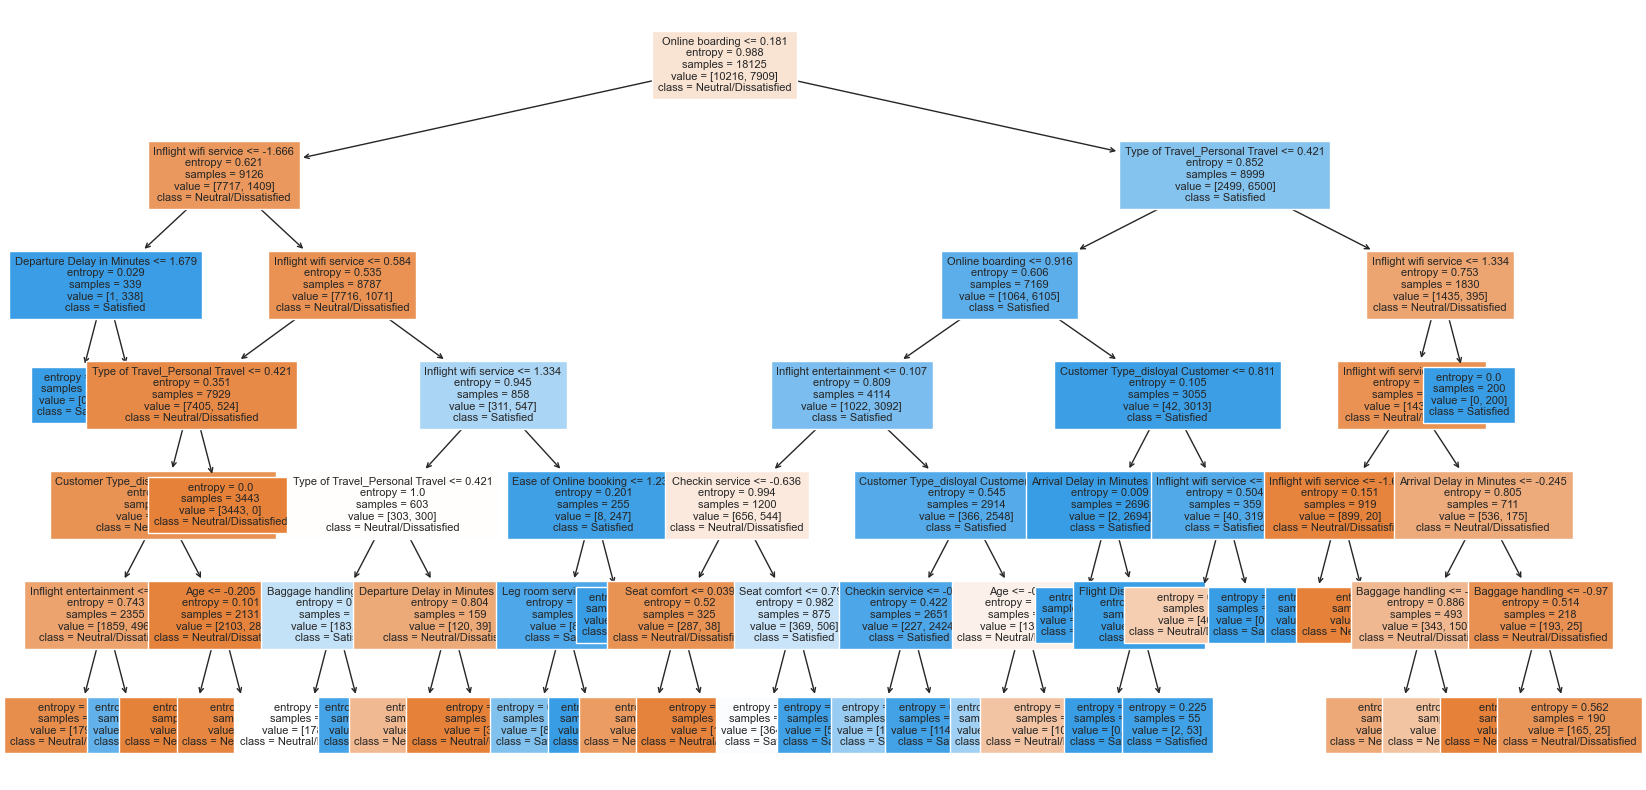

In [110]:
%matplotlib inline


#train a very simple model
tree_2 = DecisionTreeClassifier(random_state=0, max_depth=6, criterion='entropy',min_samples_leaf=10, min_impurity_decrease=0,
                                min_samples_split=70) #max_depth limits the tree to one split
tree_2.fit(X_train_scaled, y_train)


#let's plot it
fig, axe = plt.subplots(figsize=(20,10))

plot_tree( tree_2, ax = axe, feature_names=X_train.columns,  
                   class_names=['Neutral/Dissatisfied', 'Satisfied'],
                      filled=True, fontsize=8
                   )



In [111]:

classificationSummary(y_train, tree_2.predict(X_train_scaled))
classificationSummary(y_test, tree_2.predict(X_test_scaled))

Confusion Matrix (Accuracy 0.9209)

       Prediction
Actual    0    1
     0 9503  713
     1  720 7189
Confusion Matrix (Accuracy 0.9159)

       Prediction
Actual    0    1
     0 4009  303
     1  350 3106


**Interpreting the confustion matrix:**

According to the confustion matrix in both sets (scaled train and scaled test) the model seems to have Good performance in predicting class 0 (neutral/not satisfied) compared to class 1 (satisfied).

For the training set the accuracy is 92.09% indicating that the model performs well on the training data. The number of false positives (FP) is 713, and the number of false negatives (FN) is 720. These represent cases where the model made incorrect predictions.

For the test set the accuracy is 91.59% indicating that the model performs reasonably well on the unseen test data. The number of false positives (FP) is 303, and the number of false negatives (FN) is 350.

Based on these observations, we can say that the decision tree model does not exhibit significant signs of overfitting. The model demonstrates reasonably consistent performance between the training set and the test set, as the accuracy on the test set is not significantly lower than the accuracy on the training set.

In [112]:
# calcuate precision and recall on the train data
tp = 7189
fp = 713
tn = 9503
fn = 720 
prc = tp / (tp + fp)
rec = tp / (tp + fn)
F1 = 2 * (prc * rec) / (prc + rec)
print ("Model's precision on trained data is %1.3f and it's recall is %1.3f and its F1 score is %1.3f" % (prc, rec,F1))

Model's precision on trained data is 0.910 and it's recall is 0.909 and its F1 score is 0.909


In [113]:
# calcuate precision and recall on the test data
tp = 3106
fp = 303
tn = 4009
fn = 350 
prc = tp / (tp + fp)
rec = tp / (tp + fn)
F1 = 2 * (prc * rec) / (prc + rec)
print ("Model's precision on test data is %1.3f and it's recall is %1.3f and its F1 score is %1.3f" % (prc, rec,F1))

Model's precision on test data is 0.911 and it's recall is 0.899 and its F1 score is 0.905


Interpreting the Precision, Recall and F1-score metrics:

**Precision:**

The precision values for the training set (91.0%) and the test set (91.1%) indicate that out of all the cases predicted as satisfied, approximately 91.0% and 91.1% are indeed satisfied, respectively. These high precision values suggest that the model has a low rate of falsely classifying customers as satisfied when they are not.

Recall (proportion of true positive predictions (satisfaction_satisfied)):

The recall values for the training set (90.9%) and the test set (89.9%) indicate that the model correctly identifies approximately 90.9% and 89.9% of the satisfied customers in the training and test sets, respectively. These values demonstrate the model's ability to capture a significant portion of the actual satisfied customers.

**F1-score:**

The F1-score values for the training set (90.9%) and the test set (90.5%) indicate a good balance between precision and recall, taking into account both false positives and false negatives. These values indicate that the model achieves a reasonable balance in accurately identifying satisfied customers while minimizing misclassifications

Overall, The model performs well on both the training and test sets, with high precision, recall, and F1-score values. These metrics suggest that the model is able to make accurate predictions and effectively capture the positive instances (satisfied customers) in the dataset.

**Even after scaling the data it did not make a difference or improvement for decision tree**
This is expected as decision tree as scaling is required for it. Nonetheless, the feature data was already scaled to begin with for the most part (see visualizations above)


### 4. KNN Model -----------------------------------------------------------------------------------------------------------

NN is type of classifier, We are going to be looking at measuers of distance, We must normalize our data which is already done. We will use the 'nearest' data points to determine what class our observation of interest belongs to.

We applied the StandardScaler after the train-test split, as we are simulating a more realistic scenario where the scaling process is only based on the training data, and the test data remains unseen until the final evaluation.

**We will be Looking at the total distance across all of the featuers in our dataset, There is one hyperparameter to tune - k! We will use a grid search to find that.**

**When we are doing parameter tuning, we will be using K-fold cross-validation to come up with an optimal set and then with a test set to make sure we are not overfitting our model.**

**For the total number of neighboers we want to try, We created a vector from 1 to 29, to try all of the K's between 1 and 29.**

**Then we setup a grie search to test all values for n_neighbors, passing in our Knn object with 15 fold cross-validation.**

In [114]:

#create a knn model
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 29)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=15)#fit model to data
knn_gscv.fit(X_train_scaled, y_train)

GridSearchCV(cv=15, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])})


#### Best K neighbors for the optimal solution

In [115]:
knn_gscv.best_params_

{'n_neighbors': 5}

**Looks like we want 5 neighbours here!, Visualizeing the results of hyperparameter tuning**

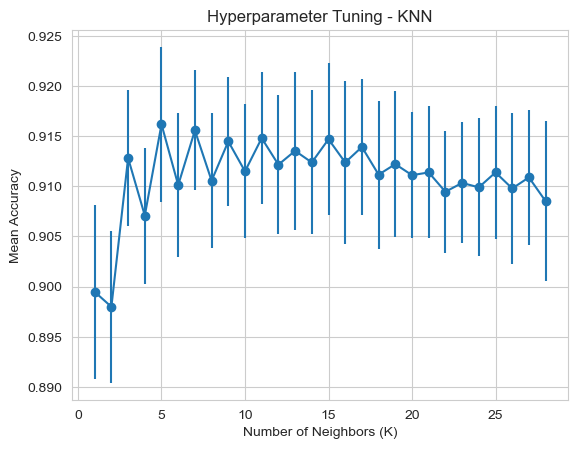

In [116]:

# Extract the results from the grid search
results = knn_gscv.cv_results_
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']
param_values = list(param_grid['n_neighbors'])

# Visualize the results using a line plot
plt.errorbar(param_values, mean_scores, yerr=std_scores, fmt='-o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Accuracy')
plt.title('Hyperparameter Tuning - KNN')
plt.grid(True)
plt.show()

In [117]:
print("Factors used in prediction:", X.columns.tolist())

Factors used in prediction: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Gender_Male', 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus']


In [118]:
#Check selected features
# Select top k features based on chi-squared test
k = 5
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_feature_indices]

print("Selected Features:", selected_features)

Selected Features: Index(['Flight Distance', 'Online boarding', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Type of Travel_Personal Travel'],
      dtype='object')


**Evaluate the KNN model performance**

In [119]:
classificationSummary(y_train, knn_gscv.predict(X_train_scaled))
classificationSummary(y_test, knn_gscv.predict(X_test_scaled))

Confusion Matrix (Accuracy 0.9378)

       Prediction
Actual    0    1
     0 9900  316
     1  812 7097
Confusion Matrix (Accuracy 0.9161)

       Prediction
Actual    0    1
     0 4123  189
     1  463 2993


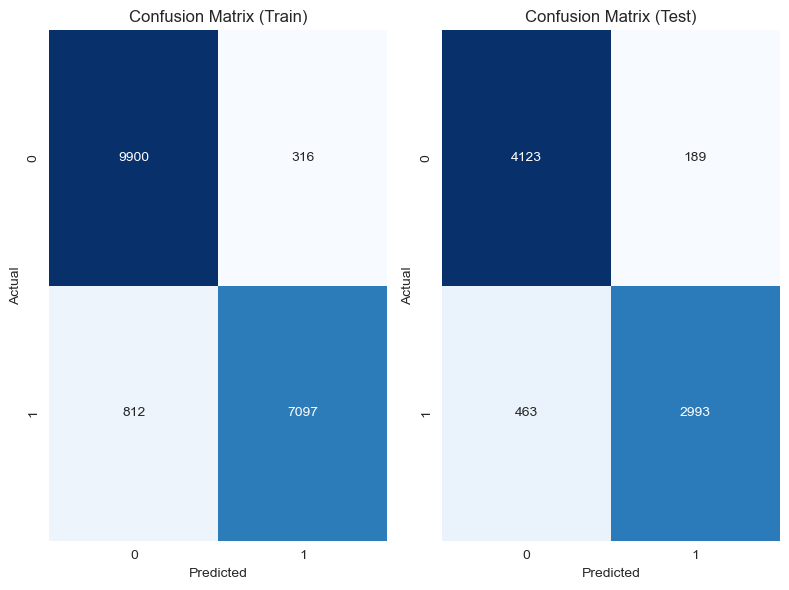

In [120]:

# Calculate Confusion Matrix
train_confusion = confusion_matrix(y_train, knn_gscv.predict(X_train_scaled))
test_confusion = confusion_matrix(y_test, knn_gscv.predict(X_test_scaled))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(test_confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

**Interpreting the confustion matrix:**

According to the confustion matrix in both sets (scaled train and scaled test) the model seems to have Good performance in predicting class 0 (satisfaction not satisfied) compared to class 1 (satisfaction satisfied).

For the training set the accuracy is 93.78% indicating that the model performs well on the training data. The number of false positives (FP) is 316, and the number of false negatives (FN) is 812. These represent cases where the model made incorrect predictions.

For the test set the accuracy is 91.61% indicating that the model performs reasonably well on the unseen test data. The number of false positives (FP) is 189, and the number of false negatives (FN) is 463.

Based on these observations, we can say that the KNN model does not exhibit significant signs of overfitting. The model demonstrates reasonably consistent performance between the training set and the test set, as the accuracy on the test set is not significantly lower than the accuracy on the training set.

In [121]:

# Calculate Precision, Recall, and F1-score
train_precision = precision_score(y_train, knn_gscv.predict(X_train_scaled))
train_recall = recall_score(y_train, knn_gscv.predict(X_train_scaled))
train_f1 = f1_score(y_train, knn_gscv.predict(X_train_scaled))

test_precision = precision_score(y_test, knn_gscv.predict(X_test_scaled))
test_recall = recall_score(y_test, knn_gscv.predict(X_test_scaled))
test_f1 = f1_score(y_test, knn_gscv.predict(X_test_scaled))

# Print Precision, Recall, and F1-score
print("\nTrain Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-score:", train_f1)

print("\nTest Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)



Train Precision: 0.9573721840010792
Train Recall: 0.8973321532431408
Train F1-score: 0.9263803680981595

Test Precision: 0.9406033940917662
Test Recall: 0.8660300925925926
Test F1-score: 0.9017776438686351


**Interpreting the Precision, Recall and F1-score metrics:**

**Precision:**

The precision values for the training set (95.7%) and the test set (94.1%) indicate that out of all the cases predicted as satisfied, approximately 95.7% and 94.1% are indeed satisfied, respectively. These high precision values suggest that the model has a low rate of falsely classifying customers as satisfied when they are not.


**Recall (proportion of true positive predictions (satisfaction_satisfied)):**

The recall values for the training set (89.7%) and the test set (86.6%) indicate that the model correctly identifies approximately 89.7% and 86.6% of the satisfied customers in the training and test sets, respectively. These values demonstrate the model's ability to capture a significant portion of the actual satisfied customers.


**F1-score:**

The F1-score values for the training set (92.6%) and the test set (90.1) indicate a good balance between precision and recall, taking into account both false positives and false negatives. These values indicate that the model achieves a reasonable balance in accurately identifying satisfied customers while minimizing misclassifications


Overall, The model performs well on both the training and test sets, with high precision, recall, and F1-score values. These metrics suggest that the model is able to make accurate predictions and effectively capture the positive instances (satisfied customers) in the dataset.